# JijModeling 1.8.0 Release Note

In [1]:
import jijmodeling as jm
import ommx.v1
import pytest

## Compiling into OMMX Message

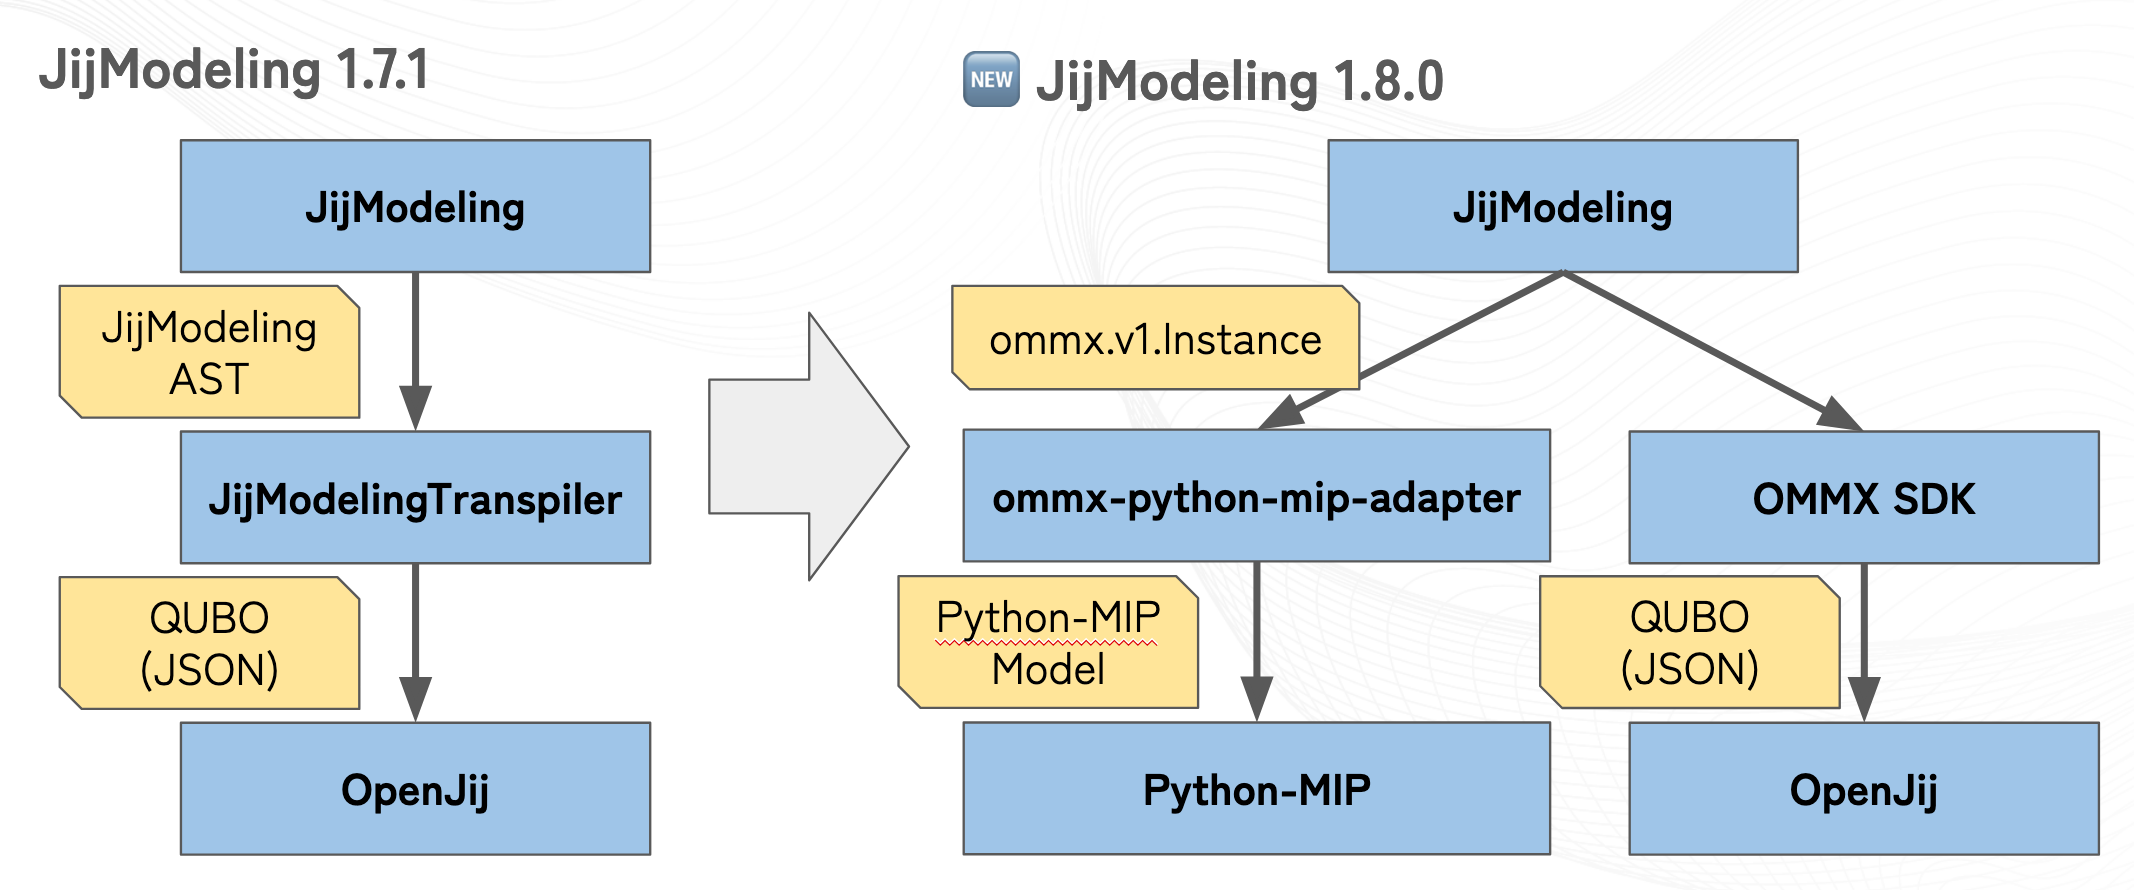

- `jijmodeling` supports stand-alone compile
  - [`jijmodeling_transpiler`](https://pypi.org/project/jijmodeling-transpiler/) or JijZept are not required now!

### `Interpreter.eval_scalar`

- `eval_scalar` evaluates JijModeling expression which does not contain decision variables into a `float`
- This will be useful for testing and debugging

In [2]:
# Initialize with instance data
interpreter = jm.Interpreter({"a": [1, 2, 3]})

# Placeholder is evaluated with instance data
a = jm.Placeholder("a", ndim=1)
assert interpreter.eval_scalar(a[1]) == 2.0

In [3]:
# Summation is supported
n = a.len_at(0, latex="n")
i = jm.Element("i", belong_to=n)
sum_a = jm.sum(i, a[i])
sum_a

sum(Element(name='i', belong_to=(NumberLit(value=0), ArrayLength(array=Placeholder(name='a', ndim=1), axis=0, latex='n'))), Placeholder(name='a', ndim=1)[Element(name='i', belong_to=(NumberLit(value=0), ArrayLength(array=Placeholder(name='a', ndim=1), axis=0, latex='n')))])

In [4]:
assert interpreter.eval_scalar(sum_a) == 1 + 2 + 3

In [5]:
# If it finds decision variable, raises error
v = jm.BinaryVar("v")
with pytest.raises(jm.InterpreterError):
    interpreter.eval_scalar(v)

### `Interpreter.eval_expr`

JijModeling expression containing decision variables are evaluated by `eval_expr` into `ommx.v1.Function`

In [6]:
# Decision variables
x = jm.BinaryVar("x", shape=(n,))

# Linear function
f = jm.sum(i, a[i] * x[i])
f

sum(Element(name='i', belong_to=(NumberLit(value=0), ArrayLength(array=Placeholder(name='a', ndim=1), axis=0, latex='n'))), Placeholder(name='a', ndim=1)[Element(name='i', belong_to=(NumberLit(value=0), ArrayLength(array=Placeholder(name='a', ndim=1), axis=0, latex='n')))] * BinaryVar(name='x', shape=[ArrayLength(array=Placeholder(name='a', ndim=1), axis=0, latex='n')])[Element(name='i', belong_to=(NumberLit(value=0), ArrayLength(array=Placeholder(name='a', ndim=1), axis=0, latex='n')))])

In [7]:
f_ = interpreter.eval_expr(f)
assert type(f_) is ommx.v1.Function
f_

Function(x0 + 2*x1 + 3*x2)

- Decision variables are registered into the interpreter when it is evaluated.
- The decision variables get their ID when they are registered. `Interpreter` issues the ID sequentially from 0.
  - Here `x[0]` has ID 0, `x[1]` has ID 1, and so on.
- Note that `__repr__` of `ommx.v1.Function` show the variables as `x0`, `x1`, ..., by their IDs since it does not contain the information of the original variable names.

In [8]:
y = jm.BinaryVar("y")
interpreter.eval_expr(y)  # Shown by their ID `x3` instead of its name `y`

Function(x3)

In [9]:
# Get corresponding decision variables in OMMX
x0 = interpreter.get_decision_variable_by_name("x", [0])
x1 = interpreter.get_decision_variable_by_name("x", [1])
x2 = interpreter.get_decision_variable_by_name("x", [2])
assert type(x0) is ommx.v1.DecisionVariable

# Compare obtained ommx.v1.Function
assert f_.almost_equal(ommx.v1.Function(x0 + 2*x1 + 3 * x2))

### `Interpreter.eval_problem`

In [10]:
problem = jm.Problem("release-1.8.0")
problem += f
problem += jm.Constraint("quad", jm.sum(i, x[i] * x[i]) == 1)
problem

In [11]:
instance = interpreter.eval_problem(problem)
assert type(instance) is ommx.v1.Instance

### Limitations

- `jijmodeling.CustomPenaltyTerm` is not supported yet.
  - This will be supported in next version with OMMX update.